In [181]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf.__version__)

2.16.1


In [182]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'
dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                      untar=True, cache_dir='.',
                                      cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')



In [183]:
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [184]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [185]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed= seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [186]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [187]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/test',
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [188]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')

In [189]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [190]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [191]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [192]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [193]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [194]:
embedding_dim = 16

In [195]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4, activation='sigmoid')
])

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [196]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [208]:
epochs = 10
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7486 - loss: 0.7611 - val_accuracy: 0.7581 - val_loss: 0.7497
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7627 - loss: 0.7274 - val_accuracy: 0.7650 - val_loss: 0.7184
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7786 - loss: 0.6977 - val_accuracy: 0.7700 - val_loss: 0.6978
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7887 - loss: 0.6672 - val_accuracy: 0.7706 - val_loss: 0.6805
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7913 - loss: 0.6440 - val_accuracy: 0.7788 - val_loss: 0.6586
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7995 - loss: 0.6187 - val_accuracy: 0.7794 - val_loss: 0.6433
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8135 - loss: 0.5978 - val_accuracy: 0.7825 - val_loss: 0.6276
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8141 - loss: 0.5742 - val_accuracy: 0.

In [209]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.7577 - loss: 0.6482
Loss:  0.6441518664360046
Accuracy:  0.7622500061988831


In [210]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

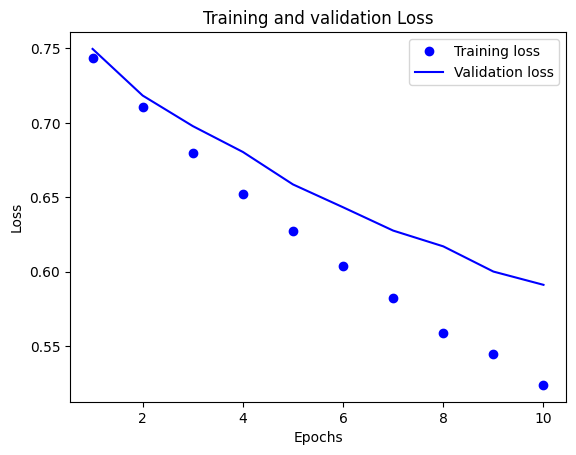

In [211]:
acc = history_dict['accuracy'],
val_acc = history_dict['val_accuracy'],
loss = history_dict['loss'],
val_loss = history_dict['val_loss']

epochs = range(1, len(acc[0]) + 1)
plt.plot(epochs, loss[0], 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

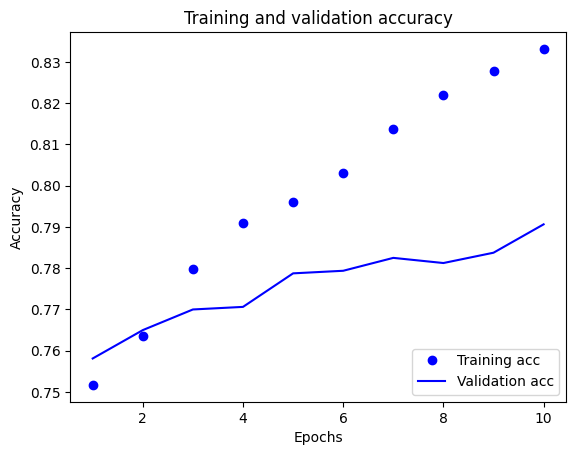

In [212]:

plt.plot(epochs, acc[0], 'bo', label='Training acc')
plt.plot(epochs, val_acc[0], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [213]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7579 - loss: 1.1268
0.7622500061988831


In [214]:
examples = tf.constant([
    "This python code is not working as expected. Print(2231). what is wrong with that ?",
    "How to log in console in C# ?",
    "What is the optimized way to call to dabase using java ?"
])

prediction = export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
